In [60]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/Nigerian_Fraud.csv')
df.head()

,sender,receiver,date,subject,body,urls,label
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 02:38:20 +0000",URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,"Thu, 31 Oct 2002 05:10:00 -0000",URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:17:55 +0100",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:44:20 -0000",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
4,Maryam Abacha <m_abacha03@www.com>,R@M,"Fri, 01 Nov 2002 01:45:04 +0100",I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1


In [3]:
df.isnull().sum()

,0
sender,331
receiver,1324
date,482
subject,39
body,0
urls,0
label,0


In [4]:
df = df.drop(["sender","receiver","date","subject"], axis=1)
df.head()

,body,urls,label
0,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1
1,"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1
2,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
3,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
4,"Dear sir, \n \nIt is with a heart full of hope...",0,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3332 entries, 0 to 3331
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    3332 non-null   object
 1   urls    3332 non-null   int64 
 2   label   3332 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 78.2+ KB


In [7]:
df["urls"].value_counts()

,count
urls,
0,2183
1,1149


In [8]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    if isinstance(text, str):  # Check if input is a string
        text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
        text = text.lower().split()
        text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
        return ' '.join(text)
    return ""  # Return an empty string if the input is not a string
df['clean_body'] = df['body'].astype(str).apply(clean_text)  # Ensure the 'sms' column is of type string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [9]:
# Train-Test Split
X = df['clean_body']
y = df['urls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_bow, y_train_resampled = smote.fit_resample(X_train_bow, y_train)

**RANDOM FOREST ALGORITHM**

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_bow, y_train_resampled)
pred_rf_bow = rf.predict(X_test_bow)
print("Random Forest (BoW):\n", classification_report(y_test, pred_rf_bow))

Random Forest (BoW):
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       459
           1       0.90      0.87      0.88       208

    accuracy                           0.93       667
   macro avg       0.92      0.91      0.92       667
weighted avg       0.93      0.93      0.93       667



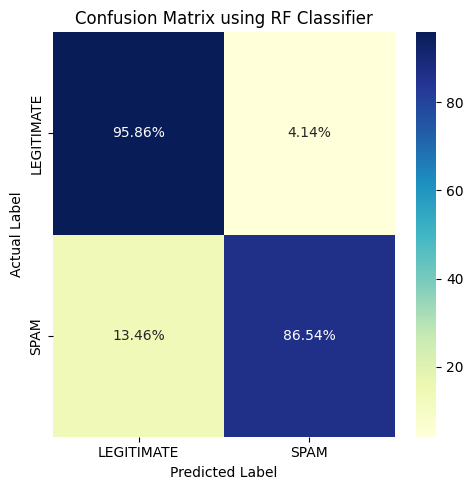

In [14]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_rf_bow)
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using RF Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

**XGBOOST**

In [15]:
# XGBoost
xgb = XGBClassifier(n_estimators = 100, eval_metric='logloss')
xgb.fit(X_train_bow, y_train_resampled)
pred_xgb_bow = xgb.predict(X_test_bow)
print("XGBoost (BoW):\n", classification_report(y_test, pred_xgb_bow))

XGBoost (BoW):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       459
           1       0.98      0.95      0.96       208

    accuracy                           0.98       667
   macro avg       0.98      0.97      0.97       667
weighted avg       0.98      0.98      0.98       667



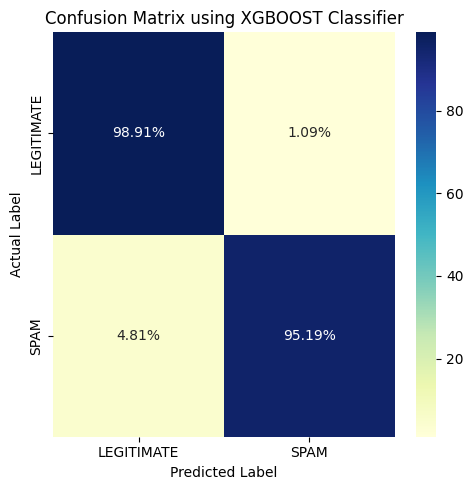

In [16]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_xgb_bow)
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using XGBOOST Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

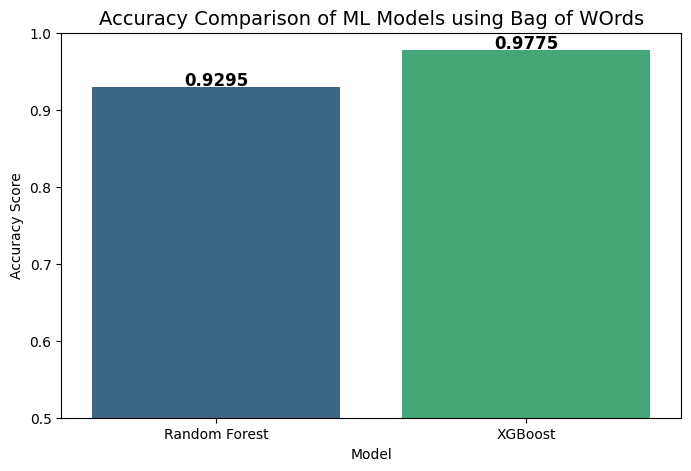

In [21]:
rf_acc = accuracy_score(y_test, pred_rf_bow)
xgb_acc = accuracy_score(y_test, pred_xgb_bow)
# Store accuracy results
accuracy_results = {
    'Random Forest': rf_acc,
    'XGBoost': xgb_acc
}
results = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])
# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')
# Add values on top of the bars
for i, value in enumerate(accuracy_results.values()):
    plt.text(i, value + 0.002, f"{value:.4f}", ha='center', fontsize=12, fontweight='bold')
plt.title('Accuracy Comparison of ML Models using Bag of WOrds', fontsize=14)
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)  # Adjust based on expected accuracy range
plt.show()

**USING TFIDF**

In [19]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
smote = SMOTE(random_state=42)
X_train_tfidf, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

**RF**

In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_tfidf, y_train_resampled)
pred_rf_tfidf = rf.predict(X_test_tfidf)
print("Random Forest (TF-IDF):\n", classification_report(y_test, pred_rf_tfidf))

Random Forest (TF-IDF):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       459
           1       0.92      0.93      0.93       208

    accuracy                           0.95       667
   macro avg       0.95      0.95      0.95       667
weighted avg       0.95      0.95      0.95       667



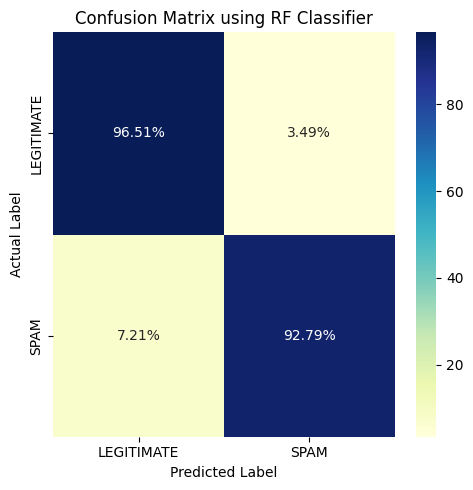

In [22]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_rf_tfidf)
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using RF Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

**XGBOOST**

In [23]:
# XGBoost
xgb = XGBClassifier(n_estimators = 100, eval_metric='logloss')
xgb.fit(X_train_tfidf, y_train_resampled)
pred_xg_tfidf = rf.predict(X_test_tfidf)
print("XGBoost (TF-IDF):\n", classification_report(y_test, pred_xg_tfidf))

XGBoost (TF-IDF):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       459
           1       0.92      0.93      0.93       208

    accuracy                           0.95       667
   macro avg       0.95      0.95      0.95       667
weighted avg       0.95      0.95      0.95       667



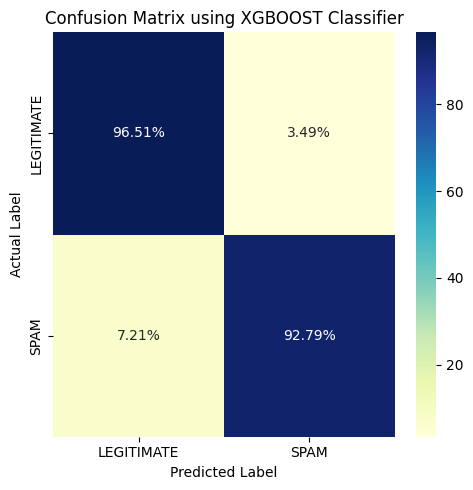

In [24]:
# Compute confusion matrix
cm = confusion_matrix(y_test, pred_xg_tfidf )
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using XGBOOST Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

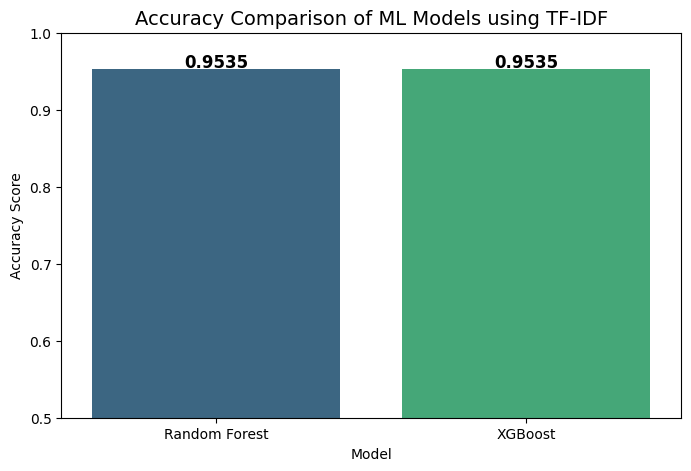

In [25]:
rf_acc = accuracy_score(y_test, pred_rf_tfidf)
xgb_acc = accuracy_score(y_test, pred_xg_tfidf)
# Store accuracy results
accuracy_results = {
    'Random Forest': rf_acc,
    'XGBoost': xgb_acc
}
results = pd.DataFrame(list(accuracy_results.items()), columns=['Model', 'Accuracy'])
# Plot bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data = results, palette='viridis')
# Add values on top of the bars
for i, value in enumerate(accuracy_results.values()):
    plt.text(i, value + 0.002, f"{value:.4f}", ha='center', fontsize=12, fontweight='bold')
plt.title('Accuracy Comparison of ML Models using TF-IDF', fontsize=14)
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)  # Adjust based on expected accuracy range
plt.show()

In [26]:
# Tokenization
max_words = 5000  # Vocabulary size
max_len = 100     # Max length of a comment

tokenizer = Tokenizer(num_words=max_words, oov_token="")
tokenizer.fit_on_texts(df['clean_body'])
sequences = tokenizer.texts_to_sequences(df['clean_body'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['urls'], test_size=0.2, random_state=42)

**LSTM**

In [27]:
# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification (positive/negative)
])
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 64)        │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 555,201 (2.12 MB)

 Trainable params: 555,201 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs= 50, batch_size= 128)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 282ms/step - accuracy: 0.6204 - loss: 0.6722 - val_accuracy: 0.7166 - val_loss: 0.5788
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - accuracy: 0.7475 - loss: 0.5548 - val_accuracy: 0.7451 - val_loss: 0.5539
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.8175 - loss: 0.4291 - val_accuracy: 0.7616 - val_loss: 0.5502
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.8712 - loss: 0.3416 - val_accuracy: 0.7481 - val_loss: 0.5803
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 386ms/step - accuracy: 0.8903 - loss: 0.2810 - val_accuracy: 0.7481 - val_loss: 0.6095
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.9134 - loss: 0.2298 - val_accuracy: 0.7166 - val_loss: 0.6667
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9217 - loss: 0.2019 - val_accuracy: 0.7196 - val_loss: 0.7423
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9306 - loss: 0.1818 - val_accurac

In [41]:
y_pred_lstm = model.predict(X_test)
y_pred_lstm = np.where(y_pred_lstm > 0.5, 1, 0).flatten()
print(classification_report(y_test, y_pred_lstm))

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       459
           1       0.54      0.56      0.55       208

    accuracy                           0.71       667
   macro avg       0.67      0.67      0.67       667
weighted avg       0.72      0.71      0.71       667



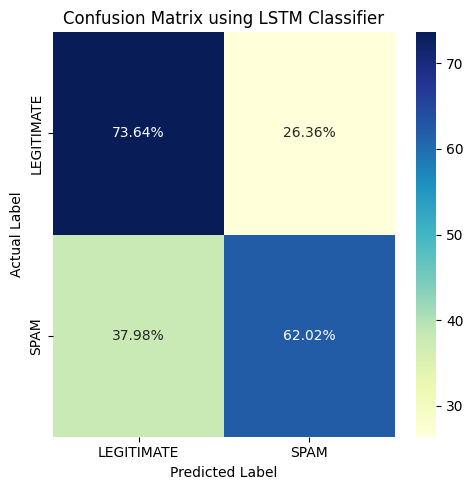

In [30]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using LSTM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

**Bi-LSTM**

In [31]:
model = Sequential([Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
                    Bidirectional(LSTM(units=128, return_sequences=False)),
                    Dense(1, activation='sigmoid')])
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build((None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,753 (2.80 MB)

 Trainable params: 734,753 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 50, batch_size = 128)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 674ms/step - accuracy: 0.6385 - loss: 0.6607 - val_accuracy: 0.7241 - val_loss: 0.5633
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 654ms/step - accuracy: 0.7389 - loss: 0.5263 - val_accuracy: 0.7676 - val_loss: 0.5245
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 649ms/step - accuracy: 0.8287 - loss: 0.3669 - val_accuracy: 0.7586 - val_loss: 0.5285
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 650ms/step - accuracy: 0.8749 - loss: 0.2998 - val_accuracy: 0.7736 - val_loss: 0.7380
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 651ms/step - accuracy: 0.9036 - loss: 0.2444 - val_accuracy: 0.7346 - val_loss: 0.6577
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 651ms/step - accuracy: 0.9235 - loss: 0.1977 - val_accuracy: 0.7001 - val_loss: 0.6728
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 615ms/step - accuracy: 0.9472 - loss: 0.1553 - val_accuracy: 0.7676 - val_loss: 0.7904
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 635ms/step - accuracy: 0.9585 - loss: 0.1078 - val_accu

In [40]:
y_pred_bi_lstm = model.predict(X_test)
y_pred_bi_lstm  = np.where(y_pred_bi_lstm  > 0.5, 1, 0).flatten()
print(classification_report(y_test, y_pred_bi_lstm))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       459
           1       0.54      0.56      0.55       208

    accuracy                           0.71       667
   macro avg       0.67      0.67      0.67       667
weighted avg       0.72      0.71      0.71       667



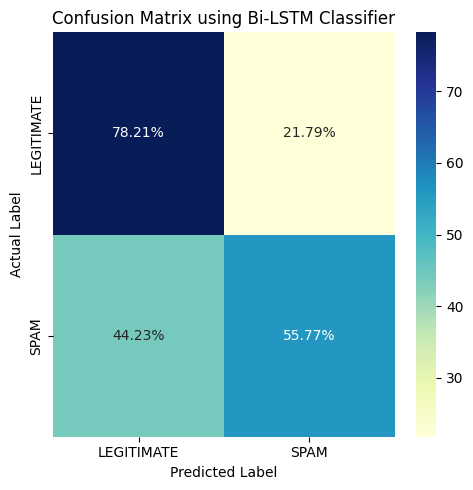

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_bi_lstm)
# Normalize by row (actual class) to get percentage
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
# Format each cell as a percentage string
labels = np.array([["{0:.2f}%".format(value) for value in row] for row in cm_percent])
# Define class labels
class_names = ["LEGITIMATE", "SPAM"]
# Plot heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(cm_percent, annot=labels, fmt='', cmap="YlGnBu", cbar=True,
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix using Bi-LSTM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

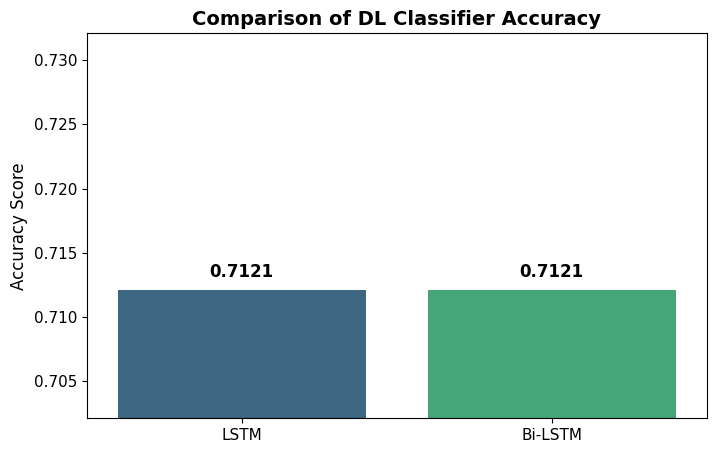

In [44]:
lstm_acc = accuracy_score(y_test, y_pred_lstm)
bi_lstm_acc = accuracy_score(y_test, y_pred_bi_lstm)
accuracy_results = {
    'LSTM': round(lstm_acc, 4),
    'Bi-LSTM': round(bi_lstm_acc, 4)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette="viridis")

for i, value in enumerate(accuracy_results.values()):
    plt.text(i, value + 0.001, f"{value:.4f}", ha='center', fontsize=12, fontweight='bold')

plt.title("Comparison of DL Classifier Accuracy", fontsize=14, fontweight='bold')
plt.ylabel("Accuracy Score", fontsize=12)
# Dynamic ylim based on actual values
min_acc = min(accuracy_results.values())
max_acc = max(accuracy_results.values())
plt.ylim(min_acc - 0.01, max_acc + 0.02)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()